In [1]:
import pandas as pd
import numpy as np
import os
import sys
import torch

import random

# 设置所有随机种子
seed = 12
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

project_root = '../../'

src_path = os.path.join(project_root, 'src')
sys.path.insert(0, project_root)
sys.path.insert(0, src_path)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = 'cpu'

In [2]:
import torch

checkpoint_path = '../../automated-concept-discovery-result/SAE-embeddings/autoencoder.pth'
checkpoint = torch.load(checkpoint_path)

In [3]:
dict_vec = checkpoint['model_state_dict']['decoder._weight'].to(device)
print(dict_vec.shape)

torch.Size([1, 768, 6144])


In [4]:
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:redlessone/PanDerm2')
tokenizer = open_clip.get_tokenizer('hf-hub:redlessone/PanDerm2')

model = model.to(device)
print(f"Loading PanDermv2")

/mnt/hdd/sdc/syyan/miniforge/envs/PanDerm-v2-SAE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tokenizer bpe_path: /mnt/hdd/sdc/syyan/My_Code/PanDerm-X/src/open_clip/bpe_simple_vocab_16e6.txt.gz


/mnt/hdd/sdc/syyan/My_Code/PanDerm-X/automated-concept-discovery/concept-retrieval/../../src/CAE/clip/modeling_clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging
/mnt/hdd/sdc/syyan/miniforge/envs/PanDerm-v2-SAE/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/mnt/hdd/sdc/syyan/miniforge/envs/PanDerm-v2-SAE/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.mo

Loading PanDermv2


In [5]:
df = pd.read_csv('../../meta-files/automated-concept-discovery/dermoscopic-melanoma/concept_meta.csv')
df['image_path'] = df['ImageID'].apply(lambda x: '../../meta-files/automated-concept-discovery/dermoscopic-melanoma/final_images/' + x)
df

,ImageID,pigment_network,blue_whitish_veil,vascular_structures,pigmentation,streaks,dots_and_globules,regression_structures,image_path
0,Nfl040.jpg,0,0,0,1,0,0,0,../../meta-files/automated-concept-discovery/d...
1,Nfl046.jpg,0,0,0,1,0,0,0,../../meta-files/automated-concept-discovery/d...
2,Nfl048.jpg,0,0,0,1,0,0,0,../../meta-files/automated-concept-discovery/d...
3,Nfl050.jpg,1,1,0,0,0,0,0,../../meta-files/automated-concept-discovery/d...
4,Ngl072.jpg,0,0,0,1,0,0,0,../../meta-files/automated-concept-discovery/d...
...,...,...,...,...,...,...,...,...,...
822,Fgl087.jpg,1,0,0,1,1,0,0,../../meta-files/automated-concept-discovery/d...
823,newl030.jpg,0,1,0,1,1,1,0,../../meta-files/automated-concept-discovery/d...
824,newl034.jpg,1,1,0,1,1,1,0,../../meta-files/automated-concept-discovery/d...
825,newl039.jpg,0,0,1,0,0,1,0,../../meta-files/automated-concept-discovery/d...


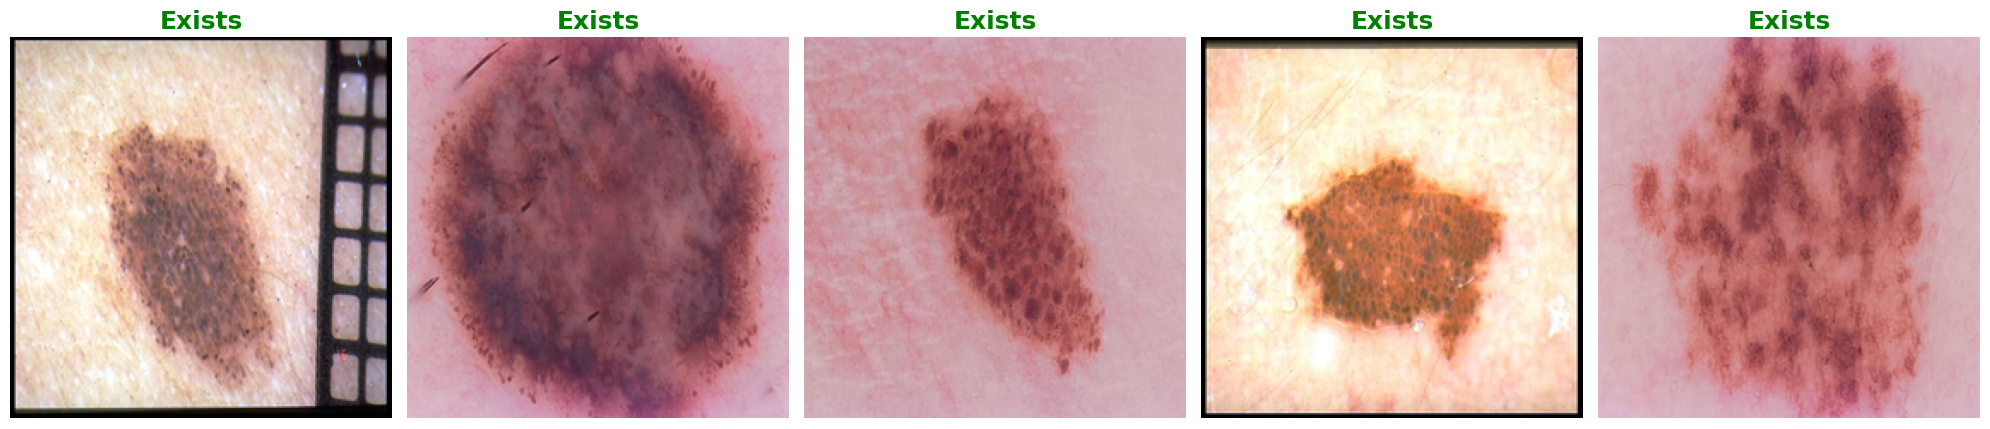

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn.functional as F
import numpy as np
import random

# Fix seed
seed = 122
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# =====================================

device = dict_vec.device
target_text = 'dots and globules' # 'dots and globules', 'streaks', 'pigment network', 'pigmentation'

target_text_list = [target_text]
learned_activation = np.load('../../automated-concept-discovery-result/dermoscopic-melanoma/learned_activation.npy')
target_text_emb = model.encode_text(tokenizer(target_text_list).to(device))
target_text_emb = target_text_emb.to(device)

# Prepare data
dict_vec_2d = F.normalize(dict_vec.squeeze(0).T, dim=-1)
target_emb = F.normalize(target_text_emb.squeeze(0), dim=-1)
activation_sums = learned_activation.sum(axis=0)

# Compute similarity
similarities = F.cosine_similarity(dict_vec_2d, target_emb, dim=1)

# Filtering
non_zero_mask = torch.from_numpy(activation_sums != 0).to(similarities.device)
similarities[~non_zero_mask] = -float('inf')

top_k = 20
values, indices = torch.topk(similarities, k=top_k, largest=True, sorted=True)

closest_neuron = indices[0].item()
neuron_idx = closest_neuron
activation_values = learned_activation[:, neuron_idx]

top_k_imgs = 5
top_indices = np.argsort(-activation_values, kind='stable')[:top_k_imgs]
top_values = activation_values[top_indices]

# Visualization
target_images = df.iloc[top_indices]
fig, axes = plt.subplots(1, 5, figsize=(20, 16))
axes = axes.flatten()

fixed_width = 224
fixed_height = 224

for i, (idx, row) in enumerate(target_images.iterrows()):
    img = Image.open(row['image_path'])
    img_resized = img.resize((fixed_width, fixed_height), Image.Resampling.LANCZOS)
    axes[i].imshow(img_resized)
    
    img_name = os.path.basename(row['image_path'])
    concept_exists = bool(row[target_text.replace(' ', '_')])
    
    if concept_exists:
        concept_label = "Exists"
        label_color = 'green'
    else:
        concept_label = "Non-Exists"
        label_color = 'red'
    
    axes[i].set_title(concept_label, color=label_color, fontsize=18, 
                     loc='center', fontweight='bold')
    axes[i].set_xlim(0, fixed_width)
    axes[i].set_ylim(fixed_height, 0)
    axes[i].set_aspect('equal')
    axes[i].axis('off')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()